In [17]:
import tensorflow as tf
import tensorlayer as tl
from pymoo.core.algorithm import Algorithm
from pymoo.operators.sampling.rnd import FloatRandomSampling
from torch.distributions import Normal, Uniform
from pymoo.core.initialization import Initialization
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.core.population import Population
from pymoo.operators.repair.bounds_repair import is_out_of_bounds_by_problem
from pymoo.core.repair import NoRepair
from torch import optim
import torch
import numpy as np
from pymoo.util.optimum import filter_optimum


[TL] WARNING: this method is DEPRECATED and has no effect, please remove it from your code.
[TL] Input  A_input: [None, array(13)]
[TL] Dense  A_l1: 13 relu
[TL] Dense  A_l2: 13 relu
[TL] Dense  A_a: 13 tanh
[TL] Lambda  lambda_18: func: <function Deep_Deterministic_policy_gradient.get_actor.<locals>.<lambda> at 0x7f36fbc5f310>, len_weights: 0
[TL] WARNING: this method is DEPRECATED and has no effect, please remove it from your code.
[TL] Input  C_s_input: [None, array(13)]
[TL] Input  C_a_input: [None, array(13)]
[TL] Concat concat_11: concat_dim: 1
[TL] Dense  C_l1: 13 relu
[TL] Dense  C_l2: 13 relu
[TL] Dense  C_out: 1 No Activation
[TL] WARNING: this method is DEPRECATED and has no effect, please remove it from your code.
[TL] Input  A_input: [None, array(13)]
[TL] Dense  A_l1: 13 relu
[TL] Dense  A_l2: 13 relu
[TL] Dense  A_a: 13 tanh
[TL] Lambda  lambda_19: func: <function Deep_Deterministic_policy_gradient.get_actor.<locals>.<lambda> at 0x7f36fbe80940>, len_weights: 0
[TL] WARNI

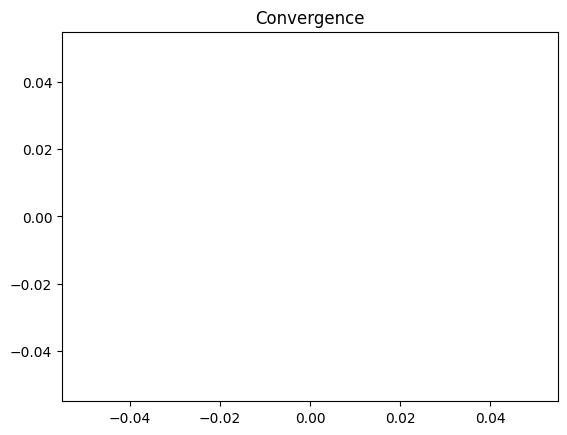

In [18]:
class Deep_Deterministic_policy_gradient(Algorithm):
    def __init__(self,
                 gamma=0.99,
                 actor_alpha=0.01,
                 critic_alpha=0.01,
                 num_rounds=20,
                 sampling=FloatRandomSampling(),
                 repair=NoRepair(),
                 memory_capacity=10000,
                 **kwargs):
        super().__init__(**kwargs)
        self.actor_alpha = actor_alpha
        self.critic_alpha = critic_alpha
        self.gamma = gamma
        self.memory_capacity = memory_capacity
        self.pointer = 0
        self.rewards = []
        self.steps_taken = []
        self.W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        self.b_init = tf.constant_initializer(0.1)
        self.initialization = Initialization(sampling)
        self.survival = RankAndCrowdingSurvival()
        self.crossover = SimulatedBinaryCrossover(n_offsprings=1)
        self.num_rounds = num_rounds
        self.repair = repair

        
    def get_actor(self,input_state_shape, name=''):
        tl.layers.set_name_reuse(True)
        input_layer = tl.layers.Input(input_state_shape, name='A_input')
        layer = tl.layers.Dense(n_units=self.n_var, act=tf.nn.relu, W_init=self.W_init, b_init=self.b_init, name='A_l1')(input_layer)
        #print("layer1",layer)
        layer = tl.layers.Dense(n_units=self.n_var, act=tf.nn.relu, W_init=self.W_init, b_init=self.b_init, name='A_l2')(layer)
        #print("layer2",layer)
        layer = tl.layers.Dense(n_units=self.n_var, act=tf.nn.tanh, W_init=self.W_init, b_init=self.b_init, name='A_a')(layer)
        #print("layer3",layer)
        layer = tl.layers.Lambda(lambda x: 0.5 * x)(layer)
        #print("layer4",layer)            
        return tl.models.Model(inputs=input_layer, outputs=layer, name='Actor3' + name)
            
    def get_critic(self,input_state_shape, input_action_shape, name=''):
        tl.layers.set_name_reuse(True)
        s = tl.layers.Input(input_state_shape, name='C_s_input')
        a = tl.layers.Input(input_action_shape, name='C_a_input')
        x = tl.layers.Concat(1)([s, a])
        x = tl.layers.Dense(n_units=self.n_var, act=tf.nn.relu, W_init=self.W_init, b_init=self.b_init, name='C_l1')(x)
        x = tl.layers.Dense(n_units=self.n_var, act=tf.nn.relu, W_init=self.W_init, b_init=self.b_init, name='C_l2')(x)
        x = tl.layers.Dense(n_units=1, W_init=self.W_init, b_init=self.b_init, name='C_out')(x)
        return tl.models.Model(inputs=[s, a], outputs=x, name='Critic3' + name)
            
        

    def copy_para(self,from_model, to_model):
        for i, j in zip(from_model.trainable_weights, to_model.trainable_weights):
            j.assign(i)
        
        

    def ema_update(self):
        paras = self.actor.trainable_weights + self.critic.trainable_weights    
        self.ema.apply(paras)                                               
        for i, j in zip(self.actor_target.trainable_weights + self.critic_target.trainable_weights, paras):
            i.assign(self.ema.average(j))

    def choose_action(self, s):
        return self.actor(np.array([s], dtype=np.float32))[0]
        
    def learn(self):
        indices = np.random.choice(self.memory_capacity, size=64)    
        bt = self.memory[indices, :]                    
        bs = bt[:, :self.s_dim]                        
        ba = bt[:, self.s_dim:self.s_dim + self.n_var]  
        br = bt[:, -self.s_dim - 1:-self.s_dim]        
        bs_ = bt[:, -self.s_dim:]                     


        with tf.GradientTape() as tape:
            a_ = self.actor_target(bs_)
            q_ = self.critic_target([bs_, a_])
            y = br + self.gamma * q_
            q = self.critic([bs, ba])
            td_error = tf.losses.mean_squared_error(y, q)
        c_grads = tape.gradient(td_error, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(c_grads, self.critic.trainable_weights))
        self.ema_update()

    def store_transition(self, s, a, r, s_):
        
        s = s.astype(np.float32)
        s_ = s_.astype(np.float32)

        transition = np.hstack((s, a, r, s_))

        index = self.pointer % self.memory_capacity
        self.memory[index, :] = transition
        self.pointer += 1
    
    
    def _setup(self, problem, **kwargs):
        self.n_var = np.array(self.problem.n_var)
        self.s_dim = np.array(self.n_var)
        self.bound = np.array(self.problem.bounds())
        self.memory = np.zeros((self.memory_capacity, self.s_dim * 2 + self.n_var + 1), dtype=np.float32)
        self.actor = self.get_actor([None, self.s_dim])
        self.critic = self.get_critic([None, self.s_dim], [None, self.n_var])
        self.actor.train()
        self.critic.train()
        self.actor_target = self.get_actor([None, self.s_dim], name='_target')
        self.copy_para(self.actor, self.actor_target)
        self.actor_target.eval()

        self.critic_target = self.get_critic([None, self.s_dim], [None, self.n_var], name='_target')
        self.copy_para(self.critic, self.critic_target)
        self.critic_target.eval()

        self.R = tl.layers.Input([None, 1], tf.float32, 'r')

        self.ema = tf.train.ExponentialMovingAverage(decay=1 - 0.01)  # soft replacement

        self.actor_opt = tf.optimizers.Adam(self.actor_alpha)
        self.critic_opt = tf.optimizers.Adam(self.critic_alpha)
        
    def _initialize_infill(self):
        return self.initialization.do(self.problem, 1, algorithm=self)

    def _initialize_advance(self, infills=None, **kwargs):
        self.data_set_X = self.pop.get("X")
        #super()._initialize_advance(infills=infills, **kwargs)

    def _infill(self):
        state = self.get_starting_point()
        #normalized_state = self.state_normalization(state)
        termination_rounds = self.num_rounds 
        steps = 0
        ep_reward = 0

        while steps < termination_rounds:
            #print("self.opt.get(F)",self.opt.get("F"))
           # print("self.problem.evaluate(np.array(state))[0]",self.problem.evaluate(np.array(state))[0])
            #print("state",state)
            a = self.choose_action(np.array(state))
            a = np.clip(np.random.normal(a, 3), -2, 2)  

            new_state, reward = self.step(a,state)
            self.store_transition(state, a, reward / 10, new_state)
            if self.pointer > self.memory_capacity:
                    self.learn()
            
            state = new_state
            ep_reward += reward
            steps +=1

        #print("normalized_state2",normalized_state)
        self.data_set_X = np.vstack((self.data_set_X, state))
        #print("self.data_set_X",self.data_set_X)
        off = Population.new(X=self.data_set_X, F = self.problem.evaluate(self.data_set_X, return_values_of=["F"]))
        self.pop = off
        self.rewards.append(ep_reward)
        self.steps_taken.append(steps)
        print("Episode: {} --- Rewards: {} --- Steps: {}".format(self.n_iter, ep_reward, steps))
        return self.pop
        
    def _advance(self, infills=None, **kwargs):
        return super()._advance(infills=infills, **kwargs)
    
    
    def _finalize(self):
        return super()._finalize()
    
    def get_rewards(self, current_state, new_state):
            #print("current_state",current_state)
            #print("new_state",new_state)
            eucli_dist = self.problem.evaluate(current_state, return_values_of=["F"]) - self.problem.evaluate(new_state, return_values_of=["F"])
            #print("self.problem.evaluate(new_state)[0]",self.problem.evaluate(new_state)[0])
            #print("self.problem.evaluate(current_state)[0]",self.problem.evaluate(current_state)[0])
            Y_cv = 0
            Y_cv = self.problem.evaluate(new_state, return_values_of=["CV"])    
            if Y_cv.size > 0 or len(is_out_of_bounds_by_problem(self.problem, [new_state])) > 0:
                return -3*eucli_dist# + self.penalty_function(new_state) + Y_cv**2)
            elif eucli_dist < 0:
                return -3*eucli_dist
            elif eucli_dist > 0:
                return 3*eucli_dist
            elif eucli_dist == 0:
                return -1
            else:
                return 1*eucli_dist
    
    def penalty_function(self, state):
        return  np.sum(np.maximum(0, state - self.problem.xu)**2) + np.sum(np.maximum(0, self.problem.xl - state)**2)
    
    def get_starting_point(self):
        if self.pop.size <= 2 or np.random.random_sample() > 0:
            return self.initialization.do(self.problem, 1, algorithm=self).get("X")[0]
        else:
            new_parents = self.survival.do(self.problem, self.pop, n_survive=2)
            new_state = self.crossover.do(self.problem, [new_parents]).get("X")[0]
            return new_state
    def state_normalization(self, state):
        return (state - self.mean)/self.std



    def step(self, action, state):
        current_X = state
        X_new = current_X + action
        reward = 0
        #print("current_X:", current_X)
        #print("action:", action)
        #while len(is_out_of_bounds_by_problem(self.problem, [X_new])) > 0:           
        #    X_new = self.sampling.do(self.problem, 1, algorithm=self).get("X")[0]
        reward = self.get_rewards(current_X, X_new)
        
        
        #if self.is_constraint_model or self.problem.n_eq_constr > 0:
        #    Y_new = evlaution_of_new_points[0]
        #    Constraint_new = evlaution_of_new_points[1]
        #else:
        
        new_state = np.array(X_new)
        #print("rewards",reward)
        return new_state, reward




In [ ]:
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
import matplotlib.pyplot as plt
import numpy as np
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination
from random import randint
from pymoo.constraints.as_obj import ConstraintsAsObjective
from pymoo.termination.ftol import SingleObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.termination.default import DefaultMultiObjectiveTermination
import random

torch.manual_seed (2)

problem = get_problem("ackley", n_var=20, a=20, b=1/5, c=2 * np.pi)
problem1 = get_problem("Rastrigin", n_var=20)
problem2 = get_problem("Rosenbrock", n_var=20)
problem3 = get_problem("g1")
algorithm3 = Deep_Deterministic_policy_gradient()
res = minimize( problem3,
                algorithm3,
                save_history=False,
                termination=('n_iter', 500),
                seed = 2,
                return_least_infeasible=True,
                verbose=True)

pf = problem2.pareto_front()
print("PF",pf[0])
ind = GD(pf)
print("GD", ind(res.F))
ind2 = IGD(pf)
print("IGD", ind2(res.F))


n_evals = np.array([e.evaluator.n_eval for e in res.history])

opt = np.array([e.opt[0].F for e in res.history])
print("final result X:",res.X)
print("final result CV:",res.CV)
print(opt)
plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.plot(n_evals, np.repeat(pf[0],len(n_evals)), 'k-', lw=1,dashes=[2, 2])
#plt.yscale("log")
plt.show() 